## LDA – линейный дискриминантный анализ.

In [16]:
# %pip install -r requirements.txt 

In [40]:
import time

import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

### [1] Используя функцию make_blobs с любым random_state, сгенерировать датасет df1, в котором есть три класса с размером каждого класса 1000 объектов и 16 количественных (недискретных) признаков.

In [18]:
centers = np.array([np.repeat(1, 16), np.repeat(1, 16), np.repeat(7, 16)])
n_features = 16

X, Y = make_blobs(n_samples=3000, n_features=n_features, random_state=42, centers=centers) 

df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(n_features)])
df['target'] = Y
df['id'] = df.index

feature_columns = [col for col in df.columns if col not in ['target', 'id']]

Не забываем повторять шаги задания 1:
- ключевые характеристики датасета
- корреляции
- визуализация на всех парах переменных

In [19]:
def dataset_overview(df: pd.DataFrame) -> None:
    print(f"Размер датасета: {df.shape}")
    print(f"Количество признаков: {len(feature_columns)}")
    print(f"Количество классов: {df['target'].nunique()}")
    print("\nКоличество объектов по классам:")
    print(df['target'].value_counts())
    percent_missing = (df.isnull().sum() / len(df) * 100).round(2)
    print("\nПроцент пропусков по признакам:")
    print(percent_missing)
    display (df.describe())

In [20]:
dataset_overview(df)

Размер датасета: (3000, 18)
Количество признаков: 16
Количество классов: 3

Количество объектов по классам:
target
0    1000
1    1000
2    1000
Name: count, dtype: int64

Процент пропусков по признакам:
x1        0.0
x2        0.0
x3        0.0
x4        0.0
x5        0.0
x6        0.0
x7        0.0
x8        0.0
x9        0.0
x10       0.0
x11       0.0
x12       0.0
x13       0.0
x14       0.0
x15       0.0
x16       0.0
target    0.0
id        0.0
dtype: float64


x1           x2           x3           x4           x5  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean      2.974357     2.979541     2.987663     2.982409     3.031480   
std       3.001312     3.005619     3.015363     2.974872     2.970290   
min      -2.532818    -2.055318    -2.321115    -2.495045    -2.241514   
25%       0.655628     0.631503     0.650388     0.701646     0.730226   
50%       1.682653     1.669485     1.661245     1.670365     1.703976   
75%       6.340937     6.314537     6.372775     6.175368     6.298946   
max      10.019653     9.933403     9.955533    10.002652    10.602415   

                x6           x7           x8           x9          x10  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean      3.023118     3.012013     2.976625     3.011322     2.986331   
std       2.994766     3.022853     3.008931     3.003916     2.964809   
min      -2.329504    -2.453354    -2.159088    -2.836656    -2.199265   
25%       0.710893     0.679210     0.653664     0.681673     0.719835   
50%       1.703170     1.700291     1.635890     1.689048     1.645271   
75%       6.305552     6.437625     6.259931     6.329463     6.267908   
max      10.335268    10.536532    10.139114    10.727833     9.923554   

               x11          x12          x13          x14          x15  \
count  3000.000000  3000.000000  3000.000000  3000.000000  3000.000000   
mean      2.986404     3.029216     3.003071     2.971005     3.013250   
std       2.997509     2.996284     2.985023     3.013079     3.038382   
min      -2.922400    -2.688365    -2.375579    -2.601085    -2.655087   
25%       0.649839     0.736875     0.700843     0.651645     0.641290   
50%       1.692774     1.746617     1.691811     1.613635     1.686287   
75%       6.268501     6.343349     6.278738     6.330092     6.379903   
max       9.951197     9.935967     9.927369     9.761056    10.380614   

               x16       target           id  
count  3000.000000  3000.000000  3000.000000  
mean      3.009984     1.000000  1499.500000  
std       2.983680     0.816633   866.169729  
min      -2.232565     0.000000     0.000000  
25%       0.724749     0.000000   749.750000  
50%       1.663112     1.000000  1499.500000  
75%       6.313220     2.000000  2249.250000  
max      10.222928     2.000000  2999.000000

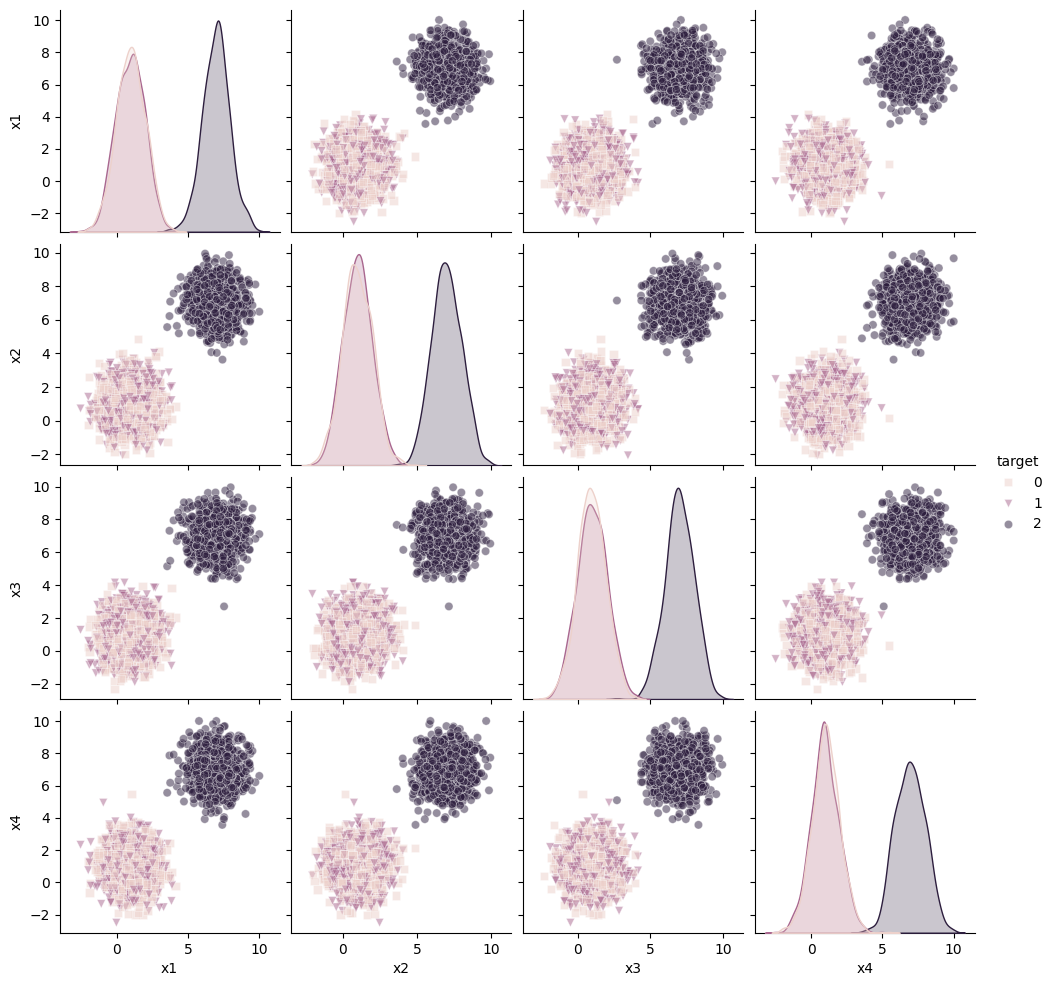

In [51]:
features_no_display = [f'x{i}' for i in range (5,17)] + ['id']
sns.pairplot(df.drop(columns=features_no_display), hue='target', markers=['s', 'v', 'o'],  plot_kws={'alpha': 0.5} )
plt.show()

In [22]:
correlation_matrix = df.drop(columns=['id']).corr()
display(correlation_matrix)

x1        x2        x3        x4        x5        x6        x7  \
x1      1.000000  0.888686  0.892341  0.884367  0.886288  0.891316  0.890489   
x2      0.888686  1.000000  0.890094  0.891775  0.887452  0.889152  0.891431   
x3      0.892341  0.890094  1.000000  0.888595  0.886064  0.892094  0.889997   
x4      0.884367  0.891775  0.888595  1.000000  0.883618  0.889328  0.885896   
x5      0.886288  0.887452  0.886064  0.883618  1.000000  0.888156  0.885235   
x6      0.891316  0.889152  0.892094  0.889328  0.888156  1.000000  0.891978   
x7      0.890489  0.891431  0.889997  0.885896  0.885235  0.891978  1.000000   
x8      0.886626  0.887252  0.885344  0.890112  0.887427  0.891064  0.889294   
x9      0.889841  0.892649  0.887363  0.892247  0.887944  0.890448  0.888805   
x10     0.888517  0.889120  0.888276  0.890962  0.891224  0.890118  0.892126   
x11     0.887329  0.883760  0.885054  0.886047  0.885981  0.886063  0.887893   
x12     0.886202  0.887470  0.892336  0.886973  0.884361  0.889220  0.896226   
x13     0.885875  0.886652  0.888886  0.889495  0.884991  0.890434  0.893217   
x14     0.891518  0.889608  0.892419  0.888099  0.886329  0.890109  0.890263   
x15     0.891194  0.890765  0.887620  0.887435  0.890594  0.888410  0.892288   
x16     0.886687  0.890429  0.889205  0.890239  0.885799  0.889838  0.891440   
target  0.813460  0.817414  0.820755  0.811041  0.814729  0.813231  0.818059   

              x8        x9       x10       x11       x12       x13       x14  \
x1      0.886626  0.889841  0.888517  0.887329  0.886202  0.885875  0.891518   
x2      0.887252  0.892649  0.889120  0.883760  0.887470  0.886652  0.889608   
x3      0.885344  0.887363  0.888276  0.885054  0.892336  0.888886  0.892419   
x4      0.890112  0.892247  0.890962  0.886047  0.886973  0.889495  0.888099   
x5      0.887427  0.887944  0.891224  0.885981  0.884361  0.884991  0.886329   
x6      0.891064  0.890448  0.890118  0.886063  0.889220  0.890434  0.890109   
x7      0.889294  0.888805  0.892126  0.887893  0.896226  0.893217  0.890263   
x8      1.000000  0.886712  0.886329  0.887814  0.890453  0.889150  0.891180   
x9      0.886712  1.000000  0.887880  0.888794  0.887610  0.885836  0.892703   
x10     0.886329  0.887880  1.000000  0.885021  0.889094  0.887375  0.891045   
x11     0.887814  0.888794  0.885021  1.000000  0.888954  0.882625  0.885801   
x12     0.890453  0.887610  0.889094  0.888954  1.000000  0.889084  0.891269   
x13     0.889150  0.885836  0.887375  0.882625  0.889084  1.000000  0.890742   
x14     0.891180  0.892703  0.891045  0.885801  0.891269  0.890742  1.000000   
x15     0.890160  0.889439  0.888833  0.888356  0.891682  0.887276  0.892607   
x16     0.888735  0.888291  0.888547  0.888217  0.888301  0.888414  0.892431   
target  0.813957  0.817324  0.817968  0.815119  0.822073  0.813958  0.818068   

             x15       x16    target  
x1      0.891194  0.886687  0.813460  
x2      0.890765  0.890429  0.817414  
x3      0.887620  0.889205  0.820755  
x4      0.887435  0.890239  0.811041  
x5      0.890594  0.885799  0.814729  
x6      0.888410  0.889838  0.813231  
x7      0.892288  0.891440  0.818059  
x8      0.890160  0.888735  0.813957  
x9      0.889439  0.888291  0.817324  
x10     0.888833  0.888547  0.817968  
x11     0.888356  0.888217  0.815119  
x12     0.891682  0.888301  0.822073  
x13     0.887276  0.888414  0.813958  
x14     0.892607  0.892431  0.818068  
x15     1.000000  0.889159  0.815354  
x16     0.889159  1.000000  0.817971  
target  0.815354  0.817971  1.000000

### [2] На основе созданного в пункте [1] датасета df1 сгенерировать отдельные дополнительные датасеты (df2, df5, df10...), в которых объекты одного класса (который имеет пересечение с другим) повторены 2 раза, 5 раз, 10 раз, 20 раз, 50 раз, 100 раз, 1000 раз, 10k раз, а количество объектов в остальных классах осталось неизменно.

In [23]:
def repeat_class(n, target=0):
    target_df = df[df['target'] == target]
    repeated_target_df = pd.concat([target_df] * n, ignore_index=True)
    non_target_df = df[df['target'] != target]
    return pd.concat([non_target_df, repeated_target_df], ignore_index=True)

df_multipliers = [1, 2, 5, 10, 20, 50, 100, 1000, 10000]
repeat_df_dict = {}
for m in df_multipliers:
    repeat_df_dict[m] = repeat_class(m)
    

repeat_df_dict[5]['target'].value_counts()

target
0    5000
1    1000
2    1000
Name: count, dtype: int64

### [3] Выбрать пару классов (включая класс с повторенными объектами) и пару количественных признаков. Используя метод LDA, для каждого из сформированных датасетов df1, df2, df5, df10, df20, df50, df100, df1000, df10k графически построить решающую функцию алгоритма, разграниченные решающей функцией зоны и отдельные объекты классов; отдельно численно вывести время построения каждого решения.
Визуализацию данного пункта лучше реализовать в паре с пунктом [5].

**Выбор:** первые два класса (они пересекаются, будет, вероятно, несколько нагляднее) и первые два признака

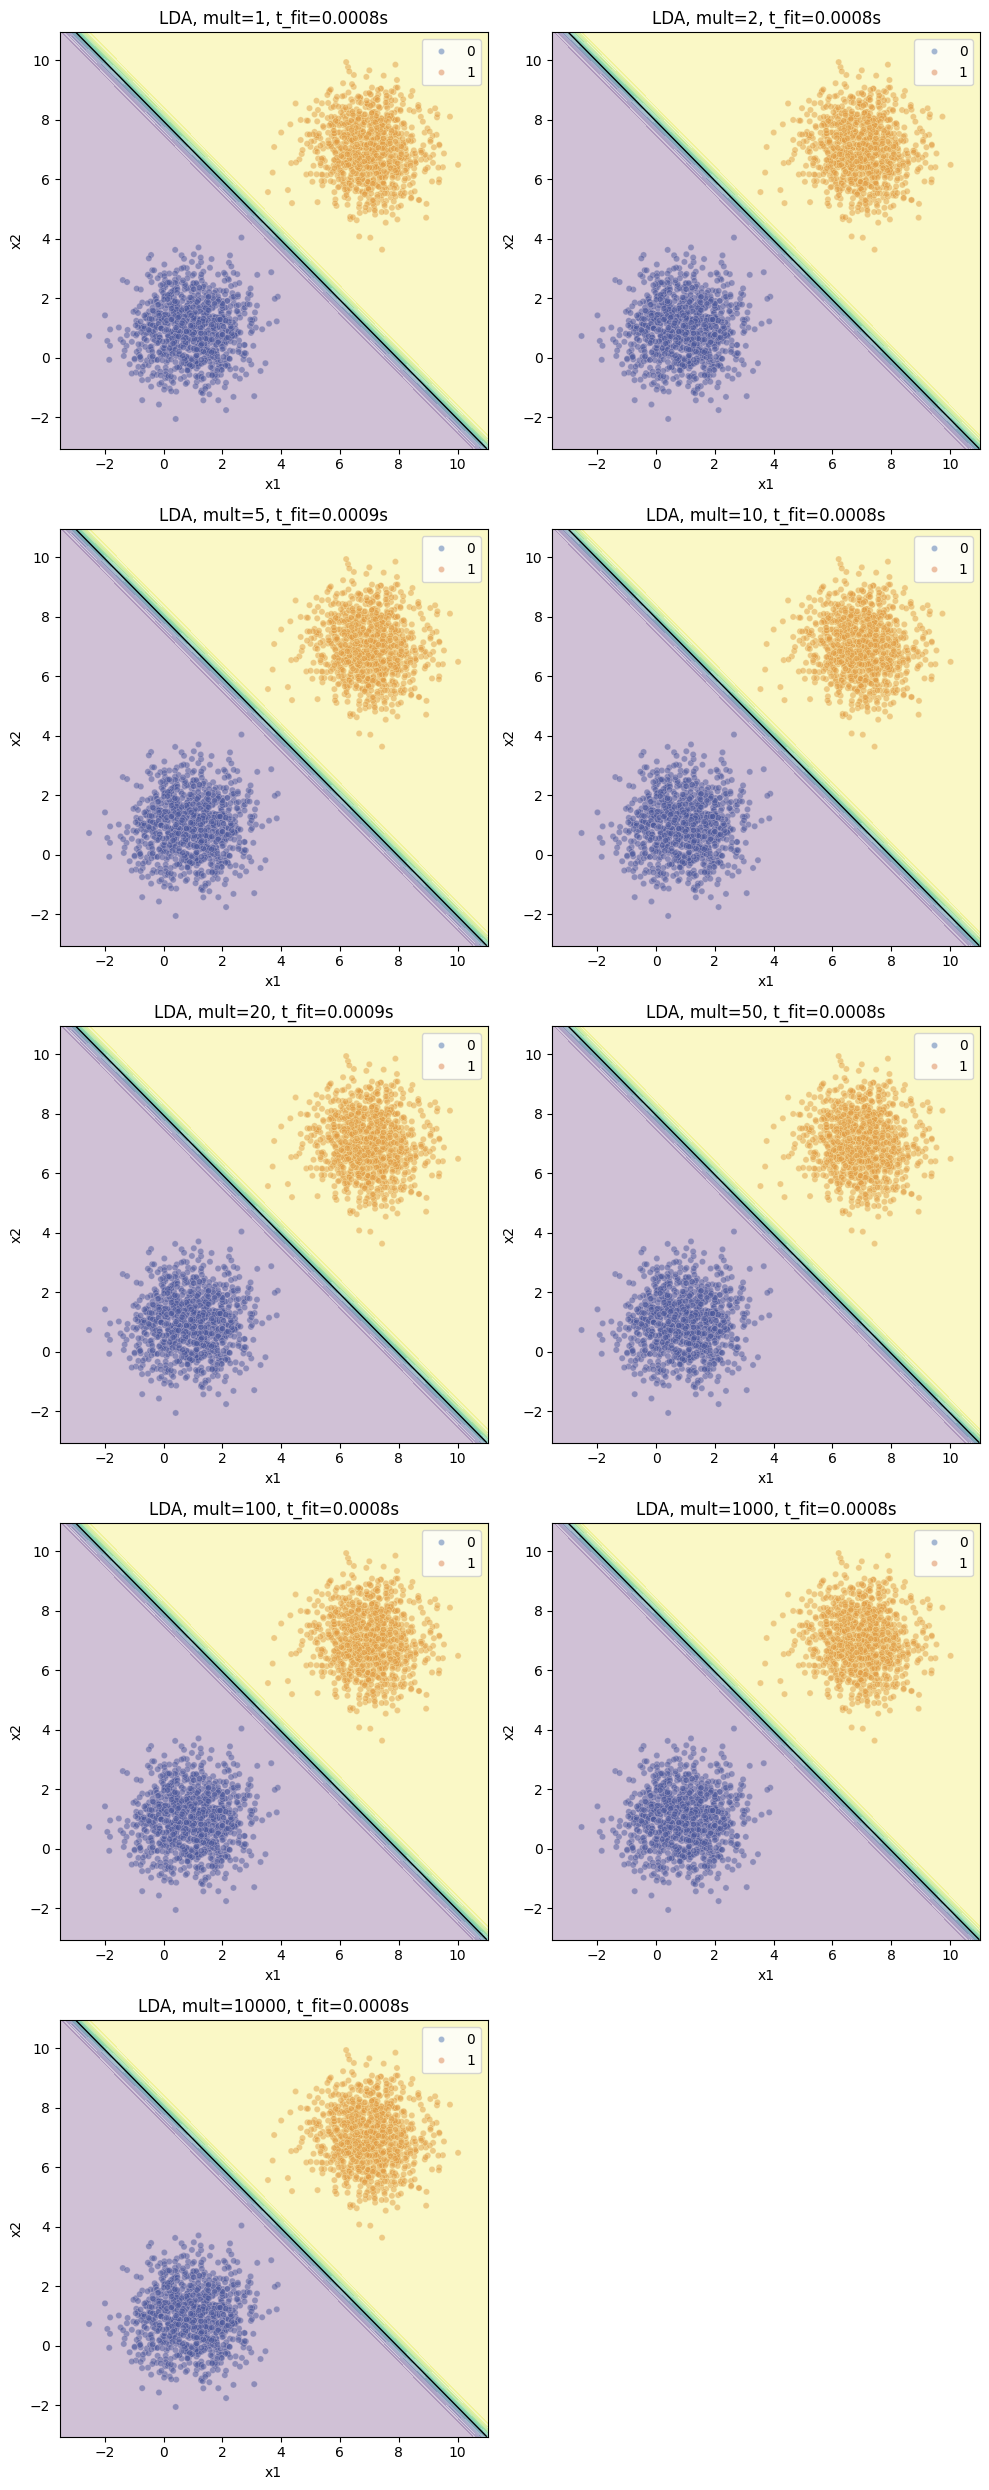

Время обучения LDA по коэффициентам увеличения:
mult=1: 0.000813 s
mult=2: 0.000804 s
mult=5: 0.000911 s
mult=10: 0.000806 s
mult=20: 0.000880 s
mult=50: 0.000790 s
mult=100: 0.000808 s
mult=1000: 0.000792 s
mult=10000: 0.000814 s


In [24]:
class_pair = (1,2)
feat_pair = ('x1','x2')

fit_times = {}

multipliers = list(df_multipliers)
n = len(multipliers)
cols = 2
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()

for idx, m in enumerate(multipliers):
    dfm = repeat_df_dict[m]

    df_sub = dfm[dfm['target'].isin(class_pair)].copy()
    X = df_sub[list(feat_pair)].values
    y = (df_sub['target'] == class_pair[1]).astype(int).values

    t0 = time.time()
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    t_fit = time.time() - t0
    fit_times[m] = t_fit

    xx_min, xx_max = X[:,0].min()-1, X[:,0].max()+1
    yy_min, yy_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300),
                         np.linspace(yy_min, yy_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    prob_grid = lda.predict_proba(grid)[:,1].reshape(xx.shape)

    ax = axes[idx]
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                    palette='deep', alpha=0.5, s=20, ax=ax)
    ax.contourf(xx, yy, prob_grid, levels=20, alpha=0.25)
    ax.contour(xx, yy, prob_grid, levels=[0.5], colors='k', linewidths=1)
    ax.set_xlabel(feat_pair[0])
    ax.set_ylabel(feat_pair[1])
    ax.set_title(f"LDA, mult={m}, t_fit={t_fit:.4f}s")

for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print("Время обучения LDA по коэффициентам увеличения:")
for m,t in fit_times.items():
    print(f"mult={m}: {t:.6f} s")

### [4] Для датасетов df1, df2, df5, df10, df20, df50, df100, df1000 из пункта [3] восстановить таблицу координаты следующих точек:
- центры масс каждого класса; - общий центр масс выбранных классов;
- центр отрезка, соединяющего центры масс выбранных классов.
Для датасетов отдельно на графиках с решающей функцией LDA вывести положения
центров масс и соединяющий центры масс классов отрезок с его центральной точкой.

mult=1 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=2 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=5 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=10 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=20 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=50 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=100 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

mult=1000 — centers (features ('x1', 'x2')):


point         x         y
0  class_1_center  0.948389  0.977096
1  class_2_center  6.976992  6.989258
2  overall_center  3.962690  3.983177
3        midpoint  3.962690  3.983177

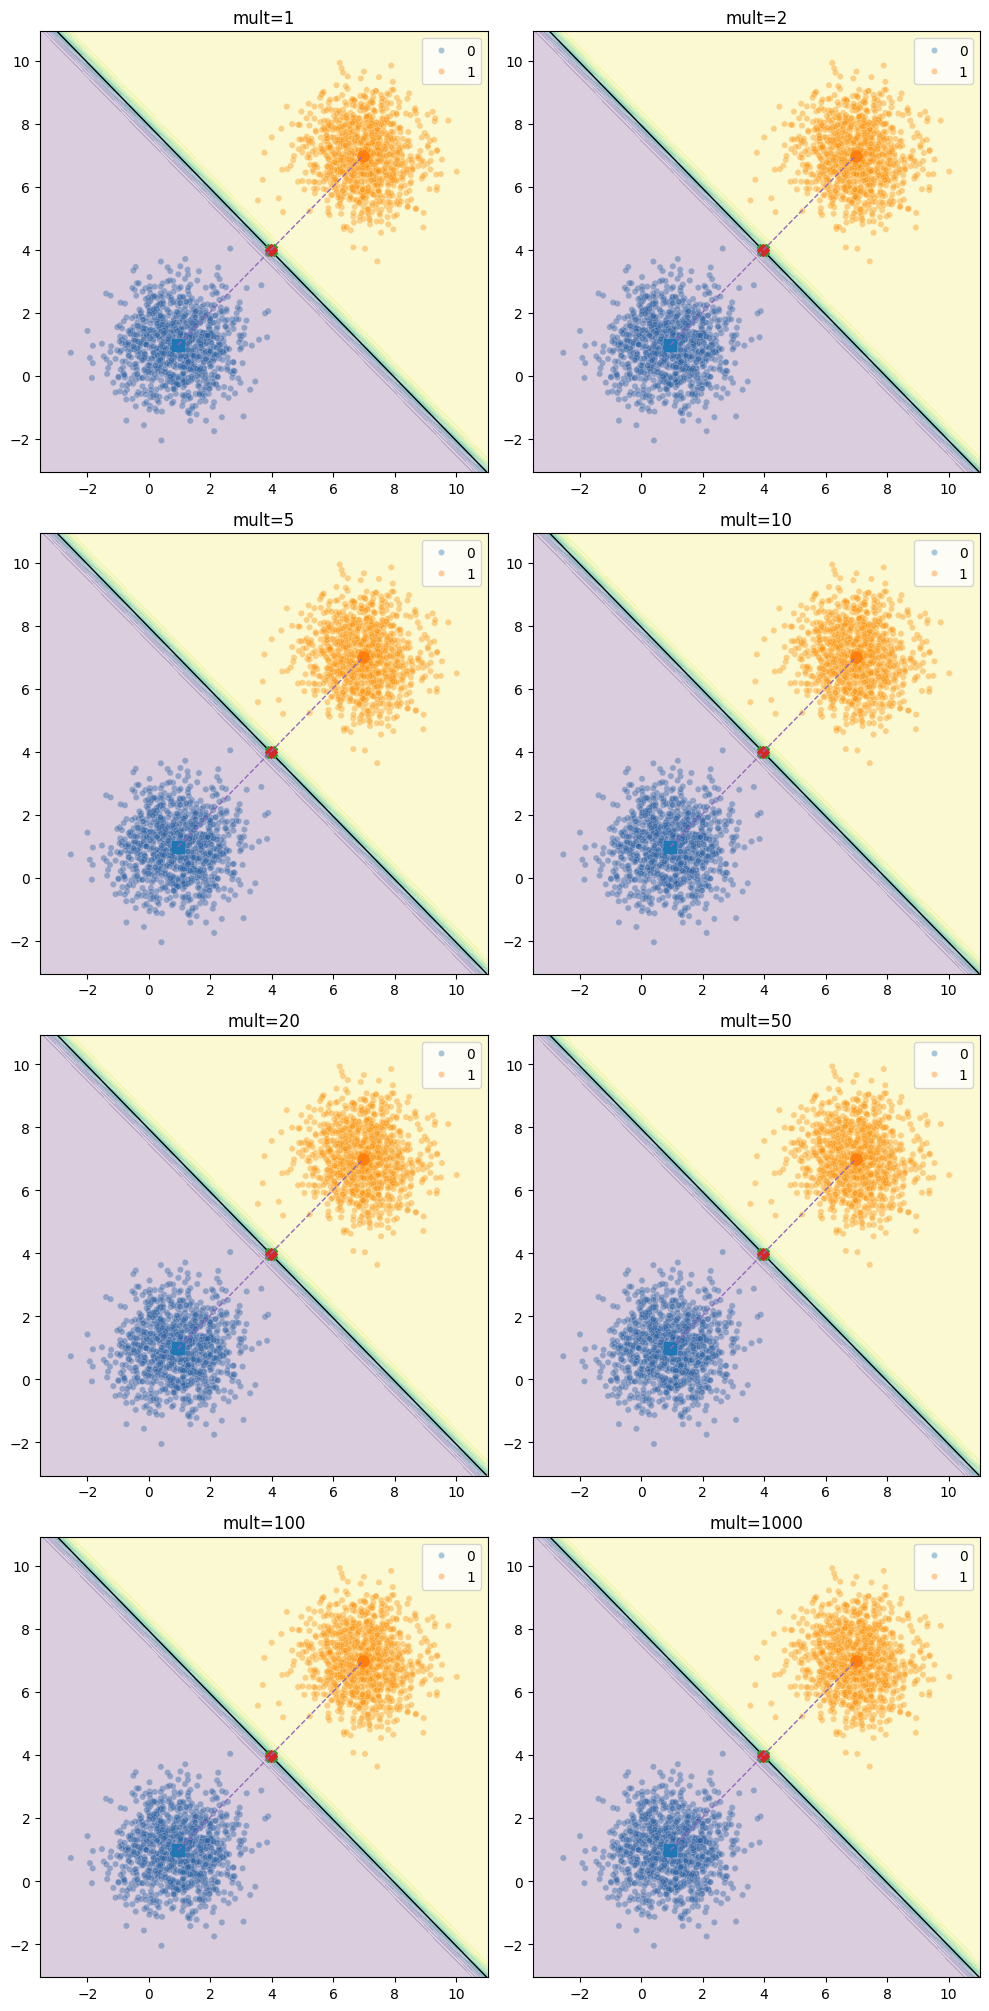

In [25]:
display_multipliers = [1,2,5,10,20,50,100,1000]

for m in display_multipliers:
    dfm = repeat_df_dict[m]
    df_sub = dfm[dfm['target'].isin(class_pair)].copy()

    centers = {
        cls: df_sub[df_sub['target']==cls][list(feat_pair)].mean().values
        for cls in class_pair
    }
    overall_center = df_sub[list(feat_pair)].mean().values
    midpoint = (centers[class_pair[0]] + centers[class_pair[1]]) / 2

    table = pd.DataFrame({
        'point': [f'class_{class_pair[0]}_center',
                  f'class_{class_pair[1]}_center',
                  'overall_center',
                  'midpoint'],
        'x': [centers[class_pair[0]][0],
              centers[class_pair[1]][0],
              overall_center[0],
              midpoint[0]],
        'y': [centers[class_pair[0]][1],
              centers[class_pair[1]][1],
              overall_center[1],
              midpoint[1]]
    })
    print(f"mult={m} — centers (features {feat_pair}):")
    display(table)

n = len(display_multipliers)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*5))
axes = axes.flatten()

for idx, m in enumerate(display_multipliers):
    dfm = repeat_df_dict[m]
    df_sub = dfm[dfm['target'].isin(class_pair)].copy()
    X = df_sub[list(feat_pair)].values
    y = (df_sub['target'] == class_pair[1]).astype(int).values

    lda = LinearDiscriminantAnalysis().fit(X, y)

    xx_min, xx_max = X[:,0].min()-1, X[:,0].max()+1
    yy_min, yy_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300),
                         np.linspace(yy_min, yy_max, 300))
    prob_grid = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)

    centers = {
        cls: df_sub[df_sub['target']==cls][list(feat_pair)].mean().values
        for cls in class_pair
    }
    overall_center = df_sub[list(feat_pair)].mean().values
    midpoint = (centers[class_pair[0]] + centers[class_pair[1]]) / 2

    ax = axes[idx]
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=0.4, s=20, ax=ax)
    ax.contourf(xx, yy, prob_grid, levels=20, alpha=0.2)
    ax.contour(xx, yy, prob_grid, levels=[0.5], colors='k', linewidths=1)

    ax.plot(*centers[class_pair[0]], 's', markersize=8)
    ax.plot(*centers[class_pair[1]], 'o', markersize=8)
    ax.plot(*overall_center, 'X', markersize=8)
    ax.plot(*midpoint, 'D', markersize=6)
    ax.plot([centers[class_pair[0]][0], centers[class_pair[1]][0]],
            [centers[class_pair[0]][1], centers[class_pair[1]][1]],
            '--', linewidth=1)

    ax.set_title(f"mult={m}")

for j in range(idx+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### [5] Выбрать целевой класс для решений из пункта [3].
Для каждого из решений из пункта [3], оценить качество работы полученных на основе LDA классификаторов, используя ROC кривые и восстановив на графике каждой ROC кривой соответствующие решению LDA 95% доверительные полосы (Confidence bands 95%) этой ROC кривой бутстрепом (n=1000 или больше). Для каждой кривой численно также отобразить метрику AUROС (AUC для ROC кривой классификации Sensitivity-Specificity и ее доверительные интервалы CI95).

*Все полученные графики возможно расположить в две колонки: левая колонка –
визуализация пространства и решений LDA, правая – графики с ROC кривой и
доверительными полосами.*

===== multiplier: 1 =====


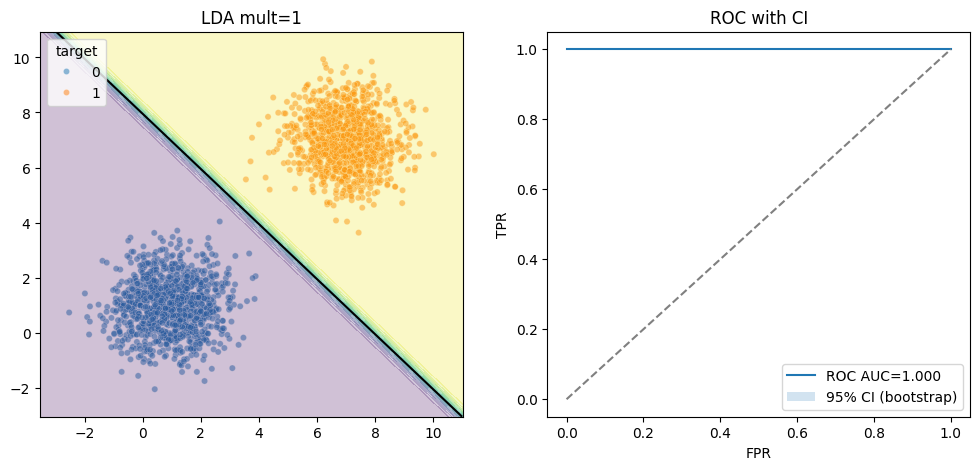

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 2 =====


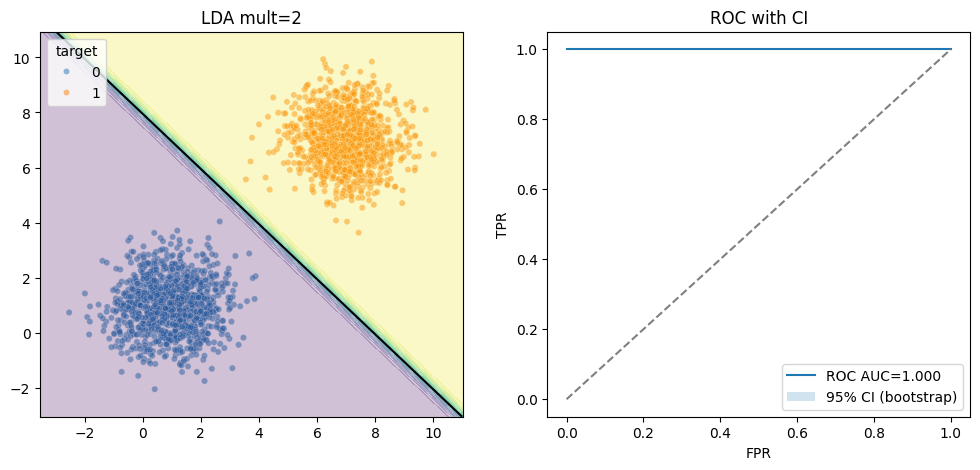

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 5 =====


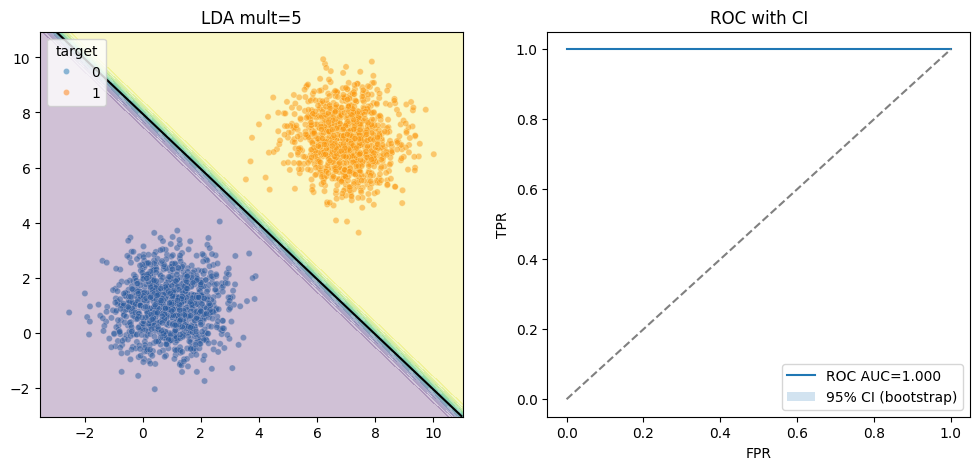

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 10 =====


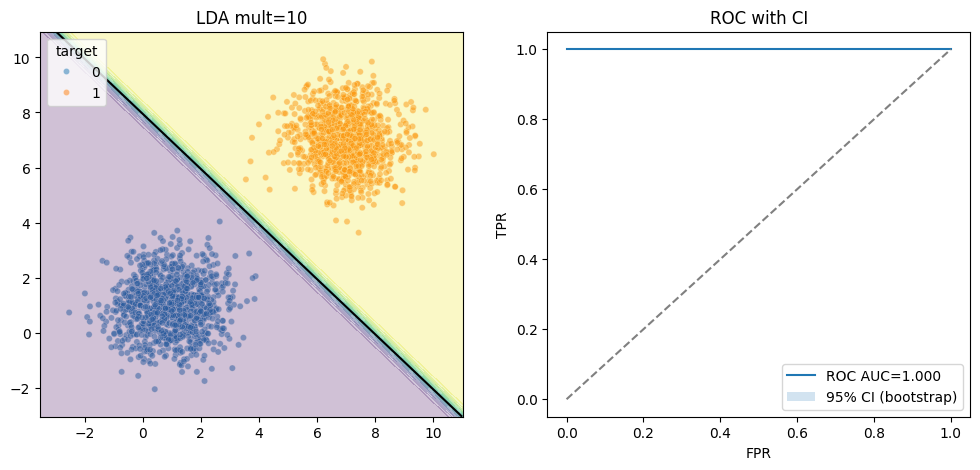

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 20 =====


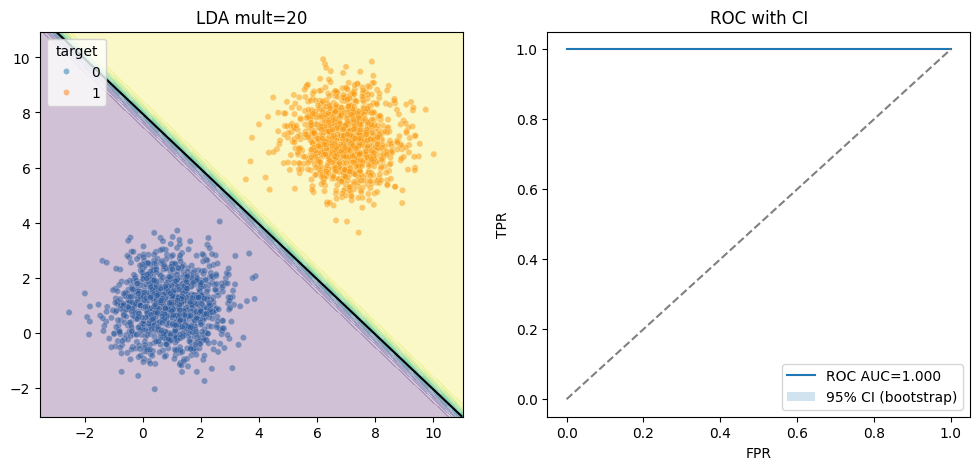

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 50 =====


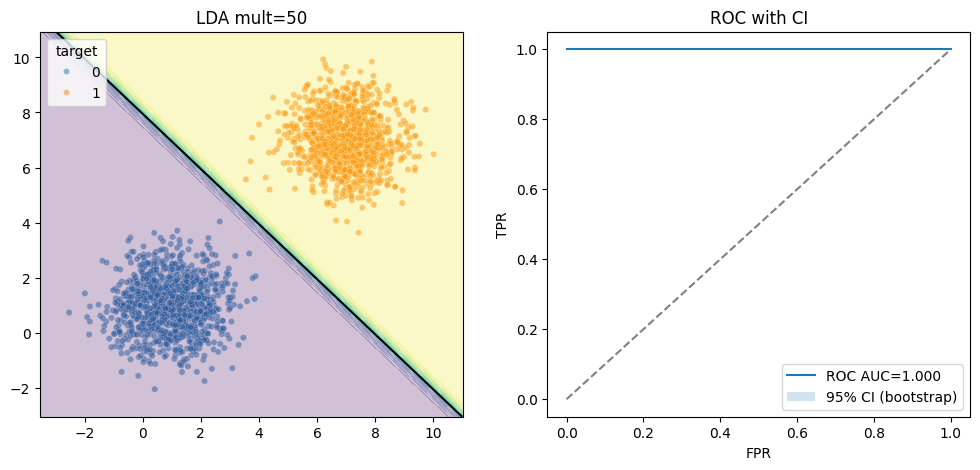

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 100 =====


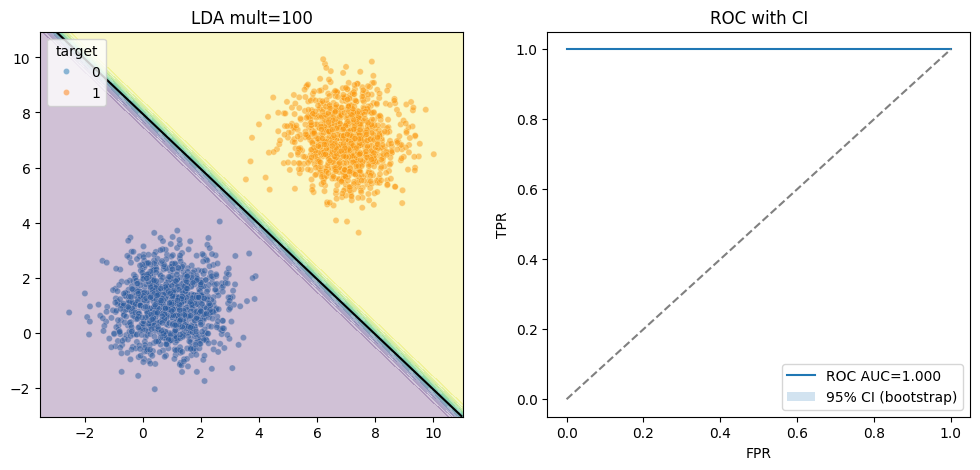

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 1000 =====


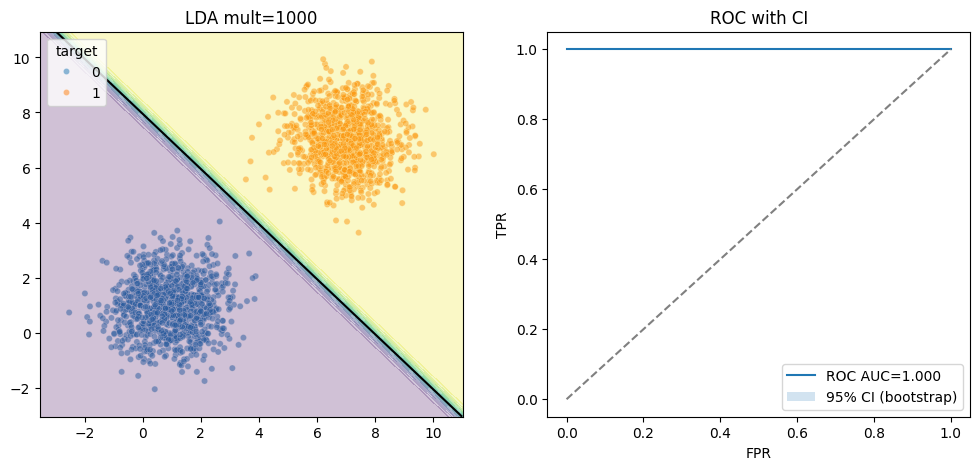

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]

===== multiplier: 10000 =====


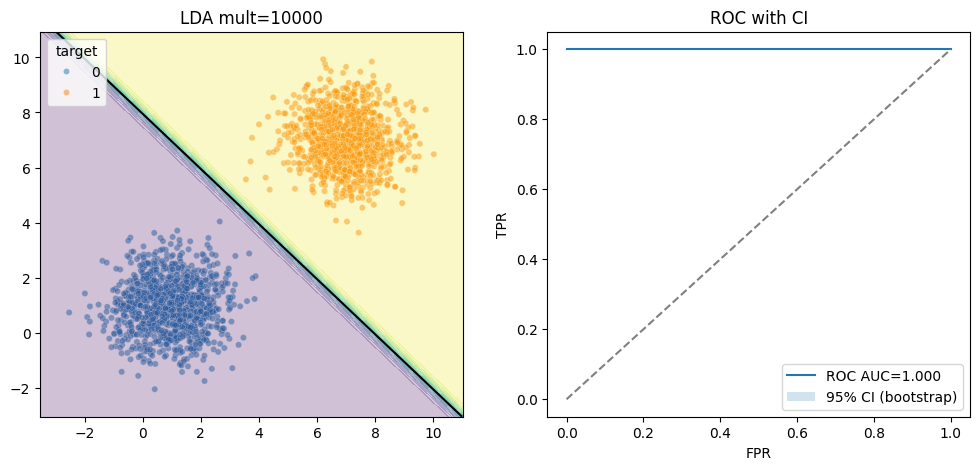

AUC mean: 1.0000, AUC CI95: [1.0000, 1.0000]



In [26]:
n_bootstrap = 1000
alpha = 0.95
fpr_grid = np.linspace(0,1,101)
target_positive = class_pair[1] 

def roc_bootstrap(y_true, y_score, n_bootstrap=1000, fpr_grid=None, seed=42, alpha=0.95):
    rng = np.random.RandomState(seed)
    if fpr_grid is None:
        fpr_grid = np.linspace(0,1,101)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    base_tpr = np.interp(fpr_grid, fpr, tpr)
    base_auc = auc(fpr, tpr)
    tprs = []
    aucs = []
    n = len(y_true)
    for i in range(n_bootstrap):
        idx = rng.randint(0, n, n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        fpr_b, tpr_b, _ = roc_curve(y_true[idx], y_score[idx])
        tprs.append(np.interp(fpr_grid, fpr_b, tpr_b))
        aucs.append(auc(fpr_b, tpr_b))
    tprs = np.array(tprs)
    lower = np.percentile(tprs, ((1-alpha)/2)*100, axis=0)
    upper = np.percentile(tprs, (alpha + (1-alpha)/2)*100, axis=0)
    auc_mean = np.mean(aucs)
    auc_ci = np.percentile(aucs, [(1-alpha)/2*100, (alpha + (1-alpha)/2)*100])
    return fpr_grid, base_tpr, lower, upper, auc_mean, auc_ci


for m in multipliers:
    print("===== multiplier:", m, "=====")
    dfm = repeat_df_dict[m]
    df_sub = dfm[dfm['target'].isin(class_pair)].copy()
    X = df_sub[list(feat_pair)].values
    y = (df_sub['target'] == target_positive).astype(int)
    lda = LinearDiscriminantAnalysis().fit(X, y)
    probs = lda.predict_proba(X)[:,1]

    fpr_g, base_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci = roc_bootstrap(y, probs, n_bootstrap=n_bootstrap, fpr_grid=fpr_grid, seed=42, alpha=alpha)

    import matplotlib.pyplot as plt
    xx_min, xx_max = X[:,0].min()-1, X[:,0].max()+1
    yy_min, yy_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300), np.linspace(yy_min, yy_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    prob_grid = lda.predict_proba(grid)[:,1].reshape(xx.shape)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=0.5, s=20, ax=ax1)
    ax1.contourf(xx, yy, prob_grid, levels=20, alpha=0.25)
    ax1.contour(xx, yy, prob_grid, levels=[0.5], colors='k')
    ax1.set_title(f"LDA mult={m}")

    ax2.plot(fpr_g, base_tpr, label=f'ROC AUC={auc_mean:.3f}')
    ax2.fill_between(fpr_g, lower_tpr, upper_tpr, alpha=0.2, label=f'{int(alpha*100)}% CI (bootstrap)')
    ax2.plot([0,1],[0,1],'--', color='gray')
    ax2.set_xlabel("FPR"); ax2.set_ylabel("TPR"); ax2.set_title("ROC with CI")
    ax2.legend()
    plt.show()

    print(f"AUC mean: {auc_mean:.4f}, AUC CI95: [{auc_ci[0]:.4f}, {auc_ci[1]:.4f}]\n")

### [6] Повторить пункт [5] для PR кривых и отобразить метрику AUPRC (AUC для PR).

===== multiplier: 1 =====


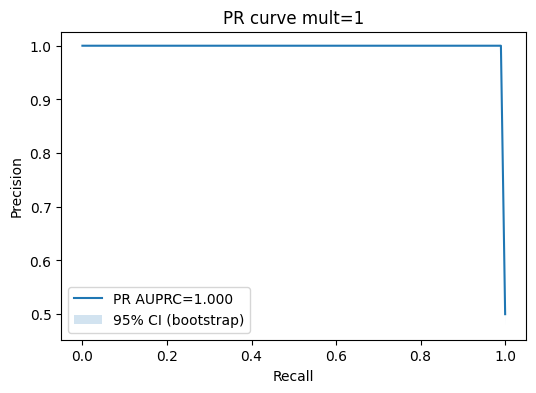

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 2 =====


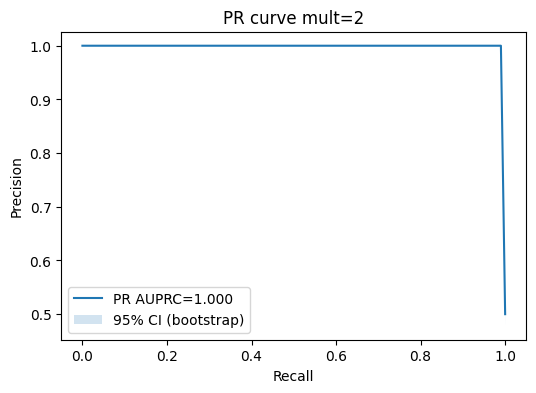

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 5 =====


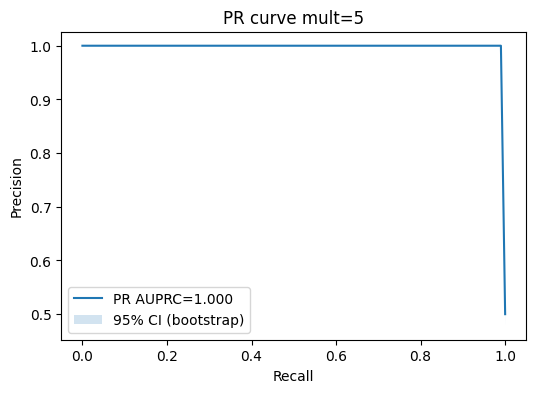

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 10 =====


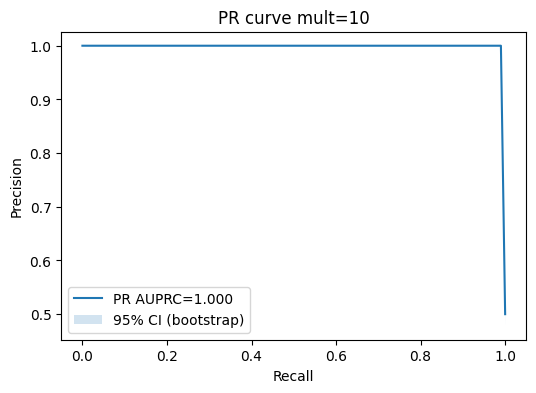

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 20 =====


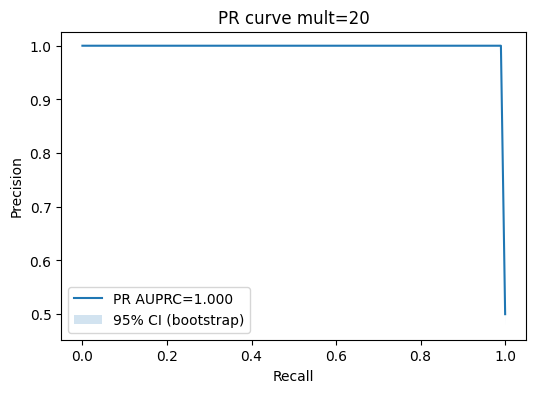

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 50 =====


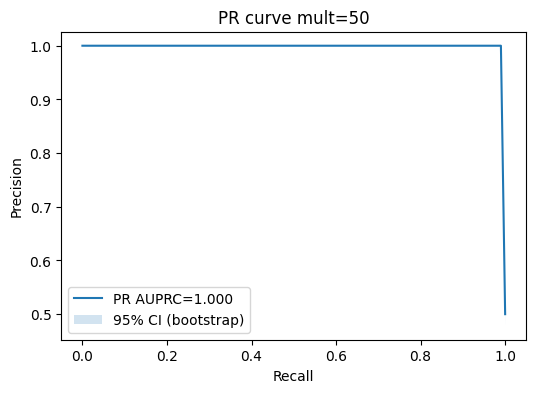

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 100 =====


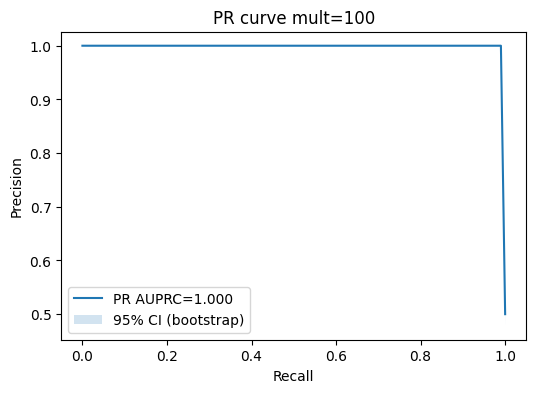

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 1000 =====


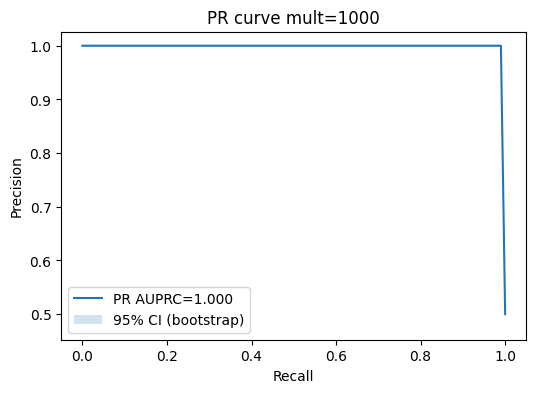

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]

===== multiplier: 10000 =====


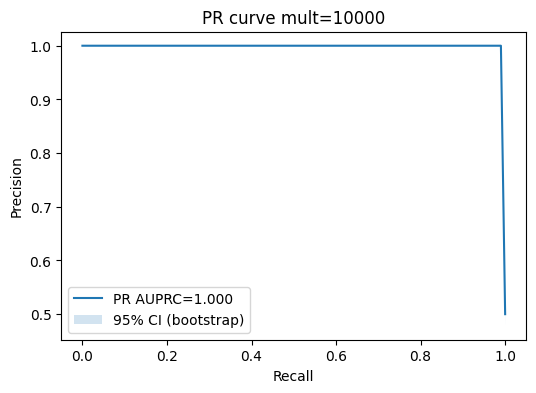

AUPRC mean: 1.0000, AUPRC CI95: [1.0000, 1.0000]



In [27]:
def pr_bootstrap(y_true, y_score, n_bootstrap=1000, recall_grid=None, seed=42, alpha=0.95):
    rng = np.random.RandomState(seed)
    if recall_grid is None:
        recall_grid = np.linspace(0,1,101)
    p, r, _ = precision_recall_curve(y_true, y_score)
    r = r[::-1]; p = p[::-1]
    base_prec = np.interp(recall_grid, r, p, left=p[0], right=p[-1])
    base_auc = average_precision_score(y_true, y_score)
    precs = []
    aucs = []
    n = len(y_true)
    for i in range(n_bootstrap):
        idx = rng.randint(0, n, n)
        if len(np.unique(y_true[idx])) < 2:
            continue
        p_b, r_b, _ = precision_recall_curve(y_true[idx], y_score[idx])
        r_b = r_b[::-1]; p_b = p_b[::-1]
        precs.append(np.interp(recall_grid, r_b, p_b, left=p_b[0], right=p_b[-1]))
        aucs.append(average_precision_score(y_true[idx], y_score[idx]))
    precs = np.array(precs)
    lower = np.percentile(precs, ((1-alpha)/2)*100, axis=0)
    upper = np.percentile(precs, (alpha + (1-alpha)/2)*100, axis=0)
    auc_mean = np.mean(aucs)
    auc_ci = np.percentile(aucs, [(1-alpha)/2*100, (alpha + (1-alpha)/2)*100])
    return recall_grid, base_prec, lower, upper, auc_mean, auc_ci

for m in multipliers:
    print("===== multiplier:", m, "=====")
    dfm = repeat_df_dict[m]
    df_sub = dfm[dfm['target'].isin(class_pair)].copy()
    X = df_sub[list(feat_pair)].values
    y = (df_sub['target'] == target_positive).astype(int)
    lda = LinearDiscriminantAnalysis().fit(X, y)
    probs = lda.predict_proba(X)[:,1]

    recall_g, base_prec, lower_p, upper_p, auprc_mean, auprc_ci = pr_bootstrap(y, probs, n_bootstrap=n_bootstrap)
    plt.figure(figsize=(6,4))
    plt.plot(recall_g, base_prec, label=f'PR AUPRC={auprc_mean:.3f}')
    plt.fill_between(recall_g, lower_p, upper_p, alpha=0.2, label=f'{int(alpha*100)}% CI (bootstrap)')
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR curve mult={m}")
    plt.legend()
    plt.show()
    print(f"AUPRC mean: {auprc_mean:.4f}, AUPRC CI95: [{auprc_ci[0]:.4f}, {auprc_ci[1]:.4f}]\n")

### [7] В пункте [5] выбрать другой целевой класс и повторить отдельно визуализации ROC кривых.

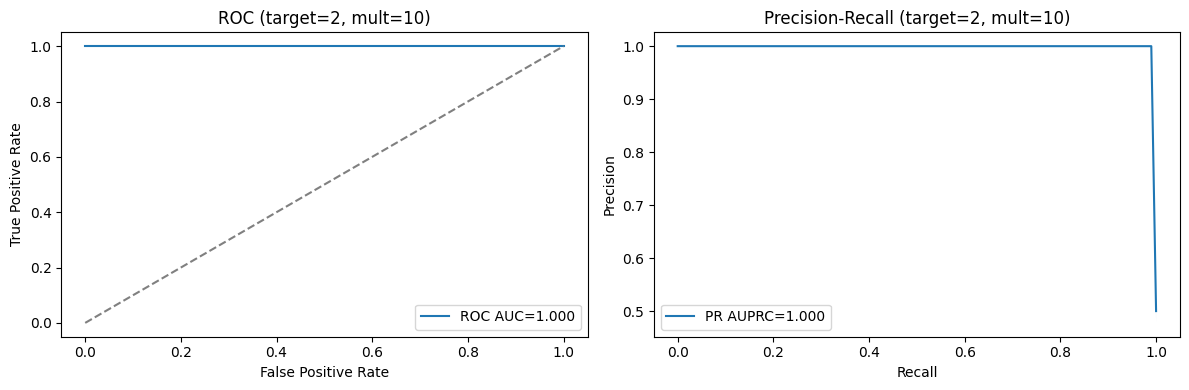

AUC: 1.0 CI95: [1. 1.]
AUPRC: 1.0 CI95: [1. 1.]


In [ ]:
target_positive = 2

m = 10
dfm = repeat_df_dict[m]
df_sub = dfm[dfm['target'].isin(class_pair)].copy()
X = df_sub[list(feat_pair)].values
y = (df_sub['target'] == target_positive).astype(int)

lda = LinearDiscriminantAnalysis().fit(X, y)
probs = lda.predict_proba(X)[:,1]

fpr_g, base_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci = roc_bootstrap(y, probs, n_bootstrap=500)

recall_g, base_prec, lower_p, upper_p, auprc_mean, auprc_ci = pr_bootstrap(y, probs, n_bootstrap=500)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(fpr_g, base_tpr, label=f'ROC AUC={auc_mean:.3f}')
ax1.fill_between(fpr_g, lower_tpr, upper_tpr, alpha=0.2)
ax1.plot([0,1], [0,1], '--', color='gray')
ax1.set_title(f"ROC (target={target_positive}, mult={m})")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()

ax2.plot(recall_g, base_prec, label=f'PR AUPRC={auprc_mean:.3f}')
ax2.fill_between(recall_g, lower_p, upper_p, alpha=0.2)
ax2.set_title(f"Precision-Recall (target={target_positive}, mult={m})")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()

plt.tight_layout()
plt.show()

print("AUC:", auc_mean, "CI95:", auc_ci)
print("AUPRC:", auprc_mean, "CI95:", auprc_ci)

### [8] Для датасета df10 на основе 3-fold, 5-fold, 10-fold, 20-fold, 50-fold, 100-fold кросс-валидации построить кривые AUROC и AUPRC c 95% доверительными полосами (CI95).
Вместо CI95 можно взять CI90, CI80 или другой квантиль доверительной полосы.

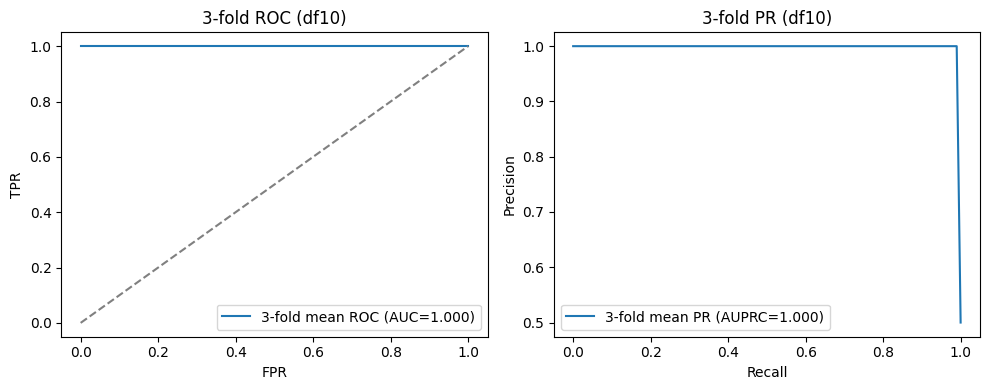

3-fold: mean AUC=1.0000 ± 0.0000; mean AUPRC=1.0000 ± 0.0000



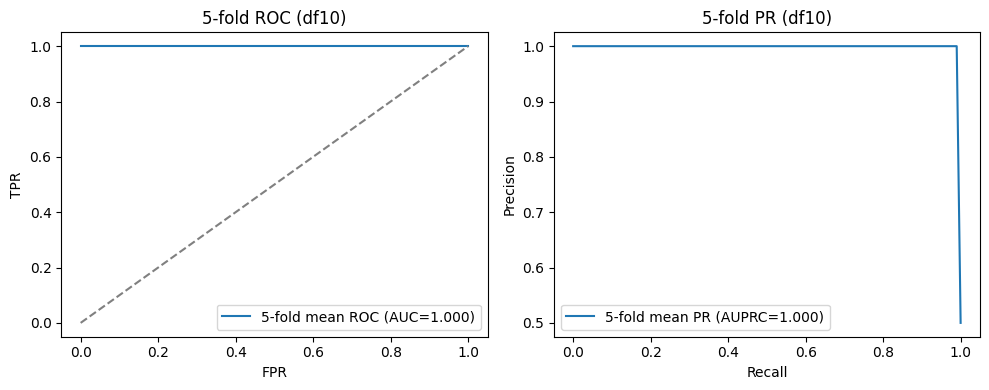

5-fold: mean AUC=1.0000 ± 0.0000; mean AUPRC=1.0000 ± 0.0000



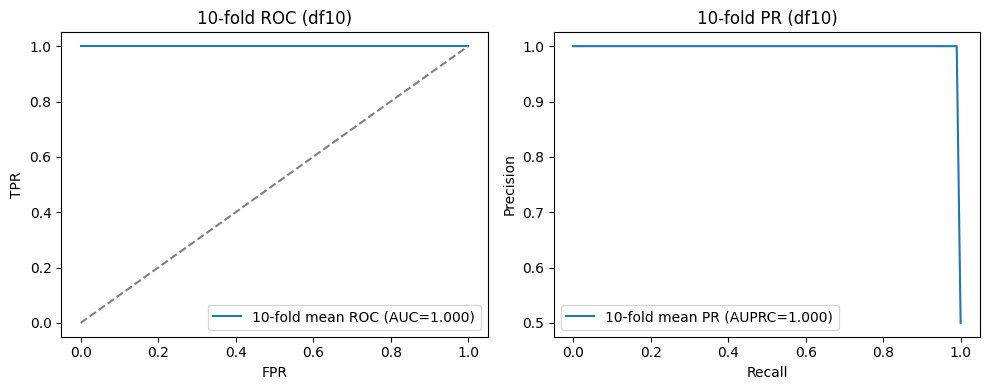

10-fold: mean AUC=1.0000 ± 0.0000; mean AUPRC=1.0000 ± 0.0000



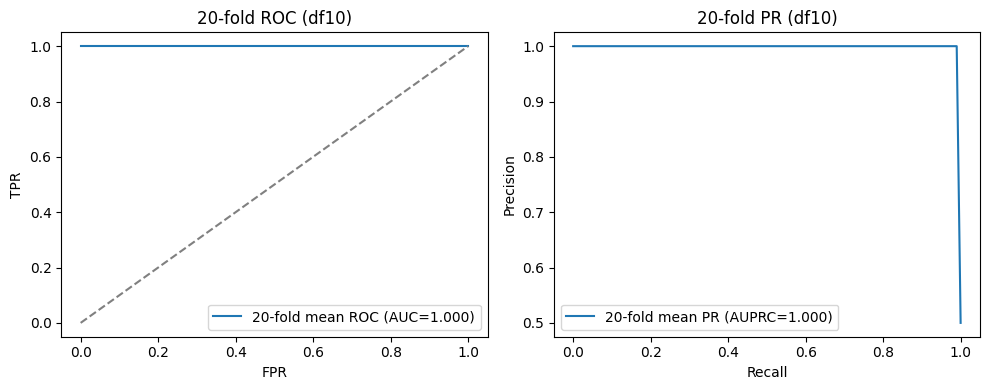

20-fold: mean AUC=1.0000 ± 0.0000; mean AUPRC=1.0000 ± 0.0000



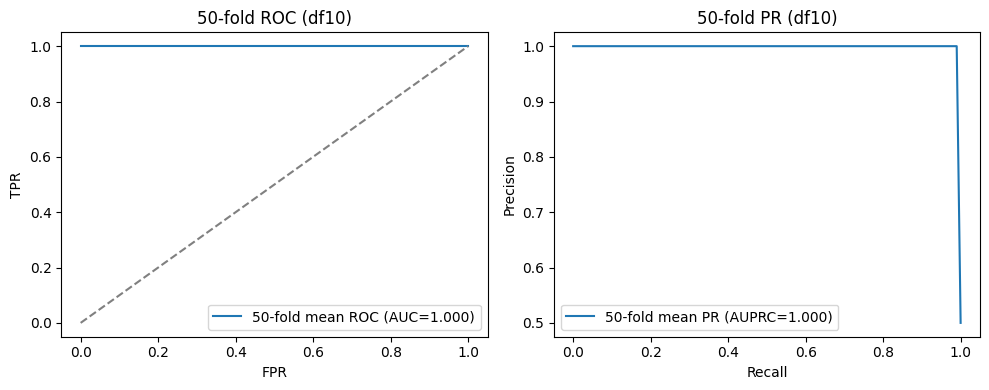

50-fold: mean AUC=1.0000 ± 0.0000; mean AUPRC=1.0000 ± 0.0000



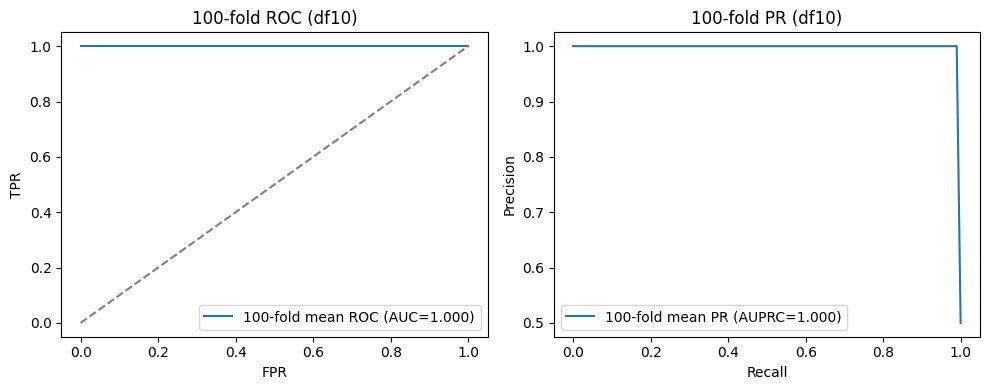

100-fold: mean AUC=1.0000 ± 0.0000; mean AUPRC=1.0000 ± 0.0000



In [36]:
df10 = repeat_df_dict[10]
df_cv = df10[df10['target'].isin(class_pair)].copy()
X_cv = df_cv[list(feat_pair)].values
y_cv = (df_cv['target'] == class_pair[1]).astype(int)

fold_list = [3,5,10,20,50,100]
mean_fpr = np.linspace(0,1,100)
recall_grid = np.linspace(0,1,100)

for k in fold_list:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    tprs = []
    aucs = []
    precisions_interp = []
    pr_aucs = []

    for train_idx, test_idx in skf.split(X_cv, y_cv):
        clf = LinearDiscriminantAnalysis().fit(X_cv[train_idx], y_cv[train_idx])
        prob = clf.predict_proba(X_cv[test_idx])[:,1]

        fpr, tpr, _ = roc_curve(y_cv[test_idx], prob)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))

        p, r, _ = precision_recall_curve(y_cv[test_idx], prob)
        p = p[::-1]
        r = r[::-1]
        precisions_interp.append(np.interp(recall_grid, r, p, left=p[0], right=p[-1]))
        pr_aucs.append(average_precision_score(y_cv[test_idx], prob))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    mean_prec = np.mean(precisions_interp, axis=0)
    std_prec = np.std(precisions_interp, axis=0)
    mean_pr_auc = np.mean(pr_aucs)
    std_pr_auc = np.std(pr_aucs)

    fig, ax = plt.subplots(1, 2, figsize=(10,4))

    ax[0].plot(mean_fpr, mean_tpr, label=f'{k}-fold mean ROC (AUC={mean_auc:.3f})')
    ax[0].fill_between(mean_fpr,
                       np.maximum(0, mean_tpr - std_tpr),
                       np.minimum(1, mean_tpr + std_tpr),
                       alpha=0.2)
    ax[0].plot([0,1],[0,1],'--', color='gray')
    ax[0].set_title(f"{k}-fold ROC (df10)")
    ax[0].set_xlabel("FPR")
    ax[0].set_ylabel("TPR")
    ax[0].legend()

    ax[1].plot(recall_grid, mean_prec, label=f'{k}-fold mean PR (AUPRC={mean_pr_auc:.3f})')
    ax[1].fill_between(recall_grid,
                       np.maximum(0, mean_prec - std_prec),
                       np.minimum(1, mean_prec + std_prec),
                       alpha=0.2)
    ax[1].set_title(f"{k}-fold PR (df10)")
    ax[1].set_xlabel("Recall")
    ax[1].set_ylabel("Precision")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

    print(f"{k}-fold: mean AUC={mean_auc:.4f} ± {std_auc:.4f}; mean AUPRC={mean_pr_auc:.4f} ± {std_pr_auc:.4f}\n")


### [9] Для датасета df1 построить решения LDA на двух, четырех, восьми и шестнадцати признаках. Для каждого решения восстановить по пункту [5] ROC кривые с доверительными полосами 95%.

2 features: AUC mean 1.0000  CI95 [1.0000, 1.0000]
4 features: AUC mean 1.0000  CI95 [1.0000, 1.0000]
8 features: AUC mean 1.0000  CI95 [1.0000, 1.0000]
16 features: AUC mean 1.0000  CI95 [1.0000, 1.0000]


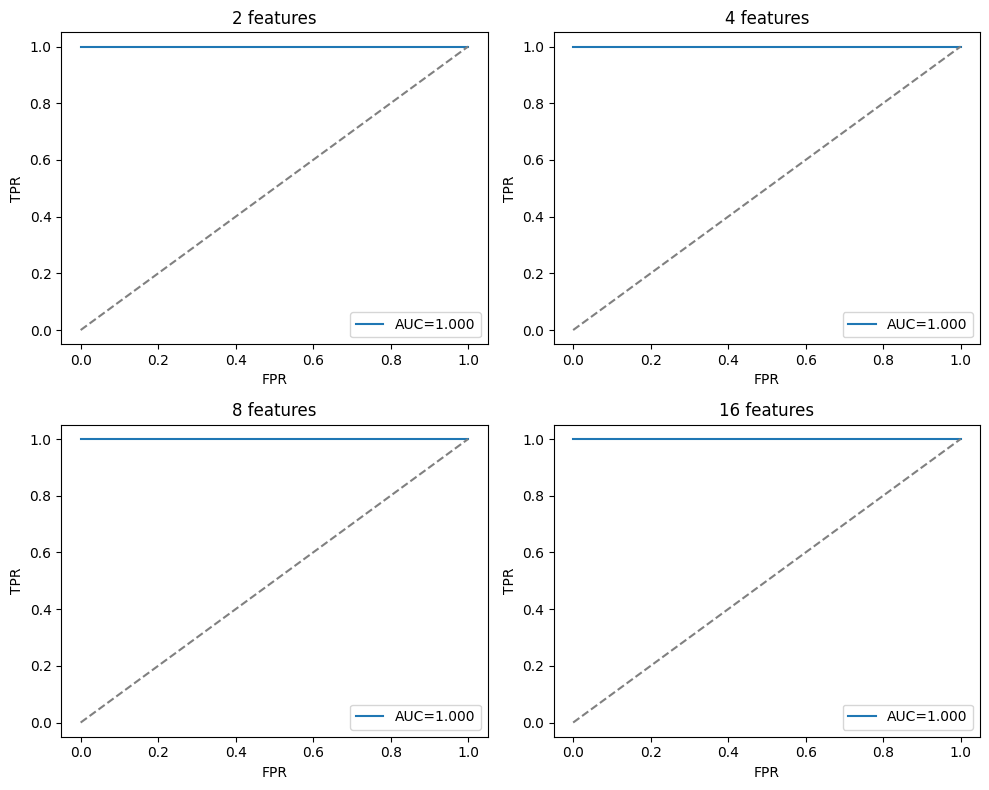

In [39]:
feature_counts = [2,4,8,16]
df_sub_all = df[df['target'].isin(class_pair)].copy()
y_all = (df_sub_all['target'] == class_pair[1]).astype(int).values

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()

for i, nf in enumerate(feature_counts):
    sel_feats = feature_columns[:nf]
    X_sel = df_sub_all[sel_feats].values
    lda = LinearDiscriminantAnalysis().fit(X_sel, y_all)
    probs = lda.predict_proba(X_sel)[:,1]

    fpr_g, base_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci = roc_bootstrap(y_all, probs, n_bootstrap=500)

    ax = axs[i]
    ax.plot(fpr_g, base_tpr, label=f'AUC={auc_mean:.3f}')
    ax.fill_between(fpr_g, lower_tpr, upper_tpr, alpha=0.2)
    ax.plot([0,1],[0,1],'--', color='gray')
    ax.set_title(f"{nf} features")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend()

    print(f"{nf} features: AUC mean {auc_mean:.4f}  CI95 [{auc_ci[0]:.4f}, {auc_ci[1]:.4f}]")

plt.tight_layout()
plt.show()


### [10*] Повторить пункты [3]+[5] для алгоритма SVM.

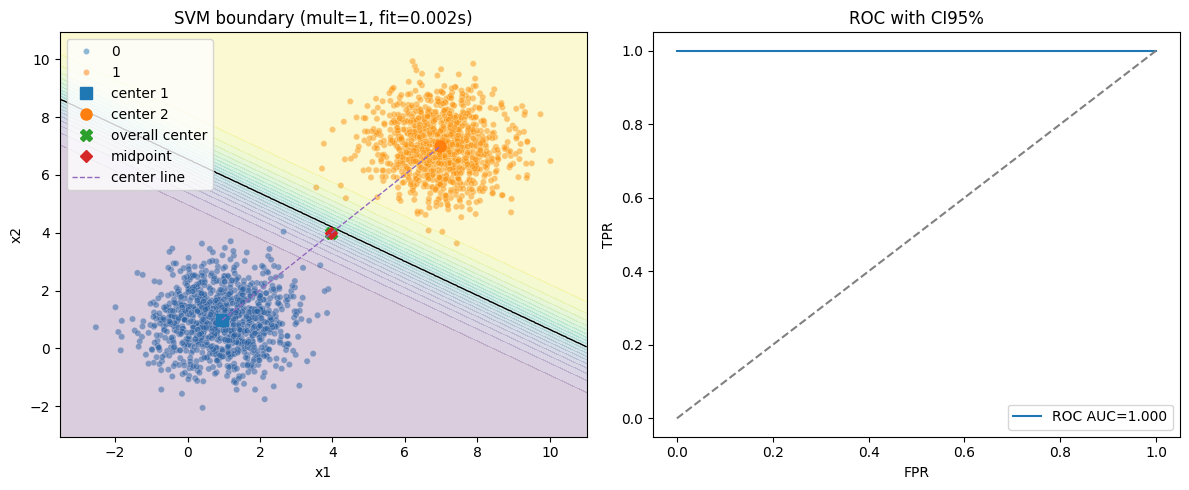

mult=1 fit time: 0.0021s | ROC AUC=1.000 CI95=[1.000, 1.000] | PR AUPRC=1.000 CI95=[1.000, 1.000]


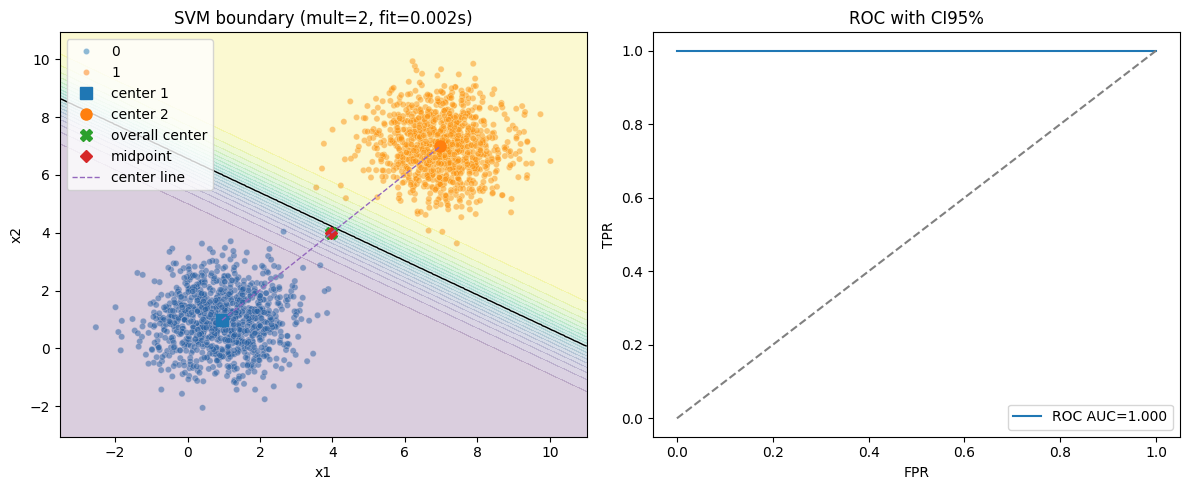

mult=2 fit time: 0.0018s | ROC AUC=1.000 CI95=[1.000, 1.000] | PR AUPRC=1.000 CI95=[1.000, 1.000]


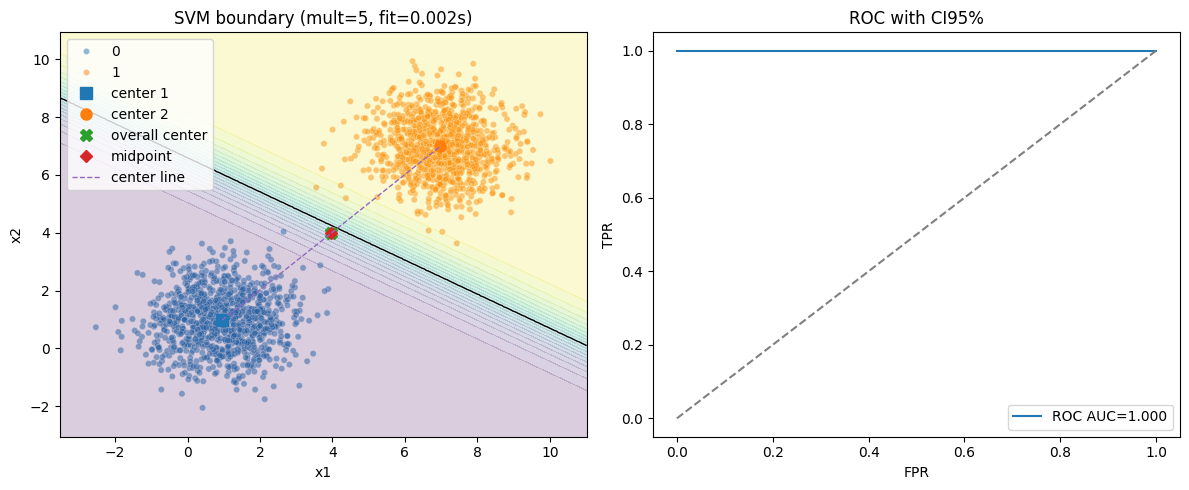

mult=5 fit time: 0.0019s | ROC AUC=1.000 CI95=[1.000, 1.000] | PR AUPRC=1.000 CI95=[1.000, 1.000]


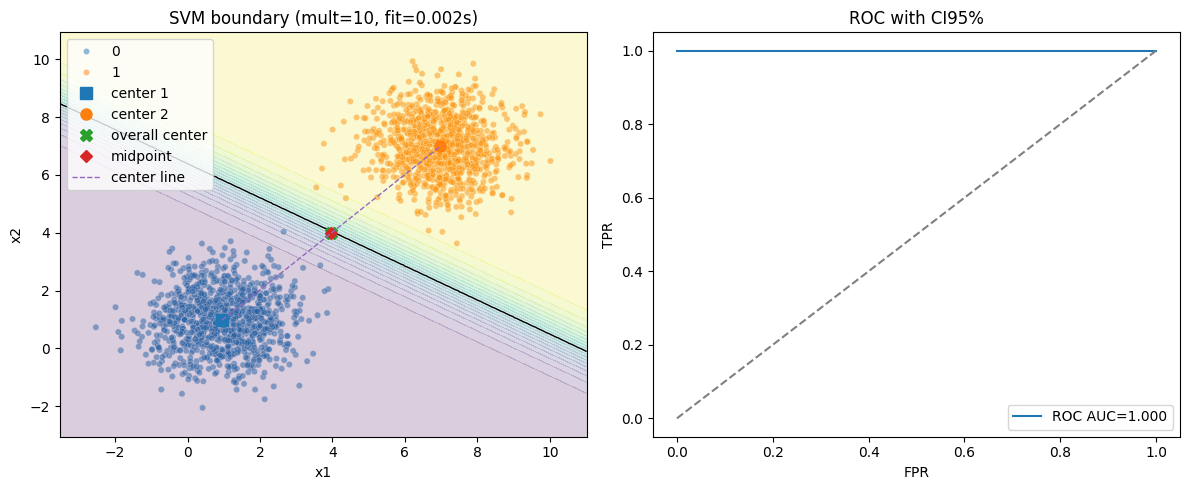

mult=10 fit time: 0.0019s | ROC AUC=1.000 CI95=[1.000, 1.000] | PR AUPRC=1.000 CI95=[1.000, 1.000]


In [43]:
class_pair = (1, 2)             
feat_pair = ('x1', 'x2')       
target_positive = class_pair[1]  
df_multipliers = [1, 2, 5, 10]  

def roc_bootstrap(y_true, y_score, n_bootstrap=500):
    fpr_grid = np.linspace(0,1,100)
    tprs = []
    aucs = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstrap):
        idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        fpr, tpr, _ = roc_curve(y_true[idx], y_score[idx])
        tpr_interp = np.interp(fpr_grid, fpr, tpr)
        tprs.append(tpr_interp)
        aucs.append(auc(fpr, tpr))
    tprs = np.array(tprs)
    mean_tpr = np.mean(tprs, axis=0)
    lower_tpr = np.percentile(tprs, 2.5, axis=0)
    upper_tpr = np.percentile(tprs, 97.5, axis=0)
    auc_mean = np.mean(aucs)
    auc_ci = np.percentile(aucs, [2.5, 97.5])
    return fpr_grid, mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci

def pr_bootstrap(y_true, y_score, n_bootstrap=500):
    recall_grid = np.linspace(0,1,100)
    precs = []
    auprcs = []
    rng = np.random.RandomState(42)
    for i in range(n_bootstrap):
        idx = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        p, r, _ = precision_recall_curve(y_true[idx], y_score[idx])
        p = p[::-1]; r = r[::-1]
        prec_interp = np.interp(recall_grid, r, p, left=p[0], right=p[-1])
        precs.append(prec_interp)
        auprcs.append(average_precision_score(y_true[idx], y_score[idx]))
    precs = np.array(precs)
    mean_prec = np.mean(precs, axis=0)
    lower_prec = np.percentile(precs, 2.5, axis=0)
    upper_prec = np.percentile(precs, 97.5, axis=0)
    auprc_mean = np.mean(auprcs)
    auprc_ci = np.percentile(auprcs, [2.5, 97.5])
    return recall_grid, mean_prec, lower_prec, upper_prec, auprc_mean, auprc_ci

for m in df_multipliers:
    dfm = repeat_df_dict[m]
    df_sub = dfm[dfm['target'].isin(class_pair)].copy()
    
    centers = {cls: df_sub[df_sub['target']==cls][list(feat_pair)].mean().values for cls in class_pair}
    overall_center = df_sub[list(feat_pair)].mean().values
    midpoint = (centers[class_pair[0]] + centers[class_pair[1]]) / 2.0
    
    X = df_sub[list(feat_pair)].values
    y = (df_sub['target'] == target_positive).astype(int).values
    
    t0 = time.time()
    svm_clf = SVC(probability=True, kernel='linear', gamma='scale').fit(X, y)
    fit_time = time.time() - t0
    
    xx_min, xx_max = X[:,0].min()-1, X[:,0].max()+1
    yy_min, yy_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(xx_min, xx_max, 300), np.linspace(yy_min, yy_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    prob_grid = svm_clf.predict_proba(grid)[:,1].reshape(xx.shape)
    
    probs = svm_clf.predict_proba(X)[:,1]
    
    fpr_g, base_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci = roc_bootstrap(y, probs, n_bootstrap=500)
    recall_g, base_prec, lower_p, upper_p, auprc_mean, auprc_ci = pr_bootstrap(y, probs, n_bootstrap=500)

    fig, axs = plt.subplots(1, 2, figsize=(12,5))
    
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, alpha=0.5, s=20, ax=axs[0])
    axs[0].contourf(xx, yy, prob_grid, levels=20, alpha=0.2)
    axs[0].contour(xx, yy, prob_grid, levels=[0.5], colors='k', linewidths=1)
    axs[0].plot(centers[class_pair[0]][0], centers[class_pair[0]][1], 's', markersize=8, label=f'center {class_pair[0]}')
    axs[0].plot(centers[class_pair[1]][0], centers[class_pair[1]][1], 'o', markersize=8, label=f'center {class_pair[1]}')
    axs[0].plot(overall_center[0], overall_center[1], 'X', markersize=8, label='overall center')
    axs[0].plot(midpoint[0], midpoint[1], 'D', markersize=6, label='midpoint')
    axs[0].plot([centers[class_pair[0]][0], centers[class_pair[1]][0]], 
                [centers[class_pair[0]][1], centers[class_pair[1]][1]], '--', linewidth=1, label='center line')
    axs[0].set_title(f"SVM boundary (mult={m}, fit={fit_time:.3f}s)")
    axs[0].set_xlabel(feat_pair[0])
    axs[0].set_ylabel(feat_pair[1])
    axs[0].legend()
    
    axs[1].plot(fpr_g, base_tpr, label=f'ROC AUC={auc_mean:.3f}')
    axs[1].fill_between(fpr_g, lower_tpr, upper_tpr, alpha=0.2)
    axs[1].plot([0,1],[0,1],'--', color='gray')
    axs[1].set_title("ROC with CI95%")
    axs[1].set_xlabel("FPR")
    axs[1].set_ylabel("TPR")
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"mult={m} fit time: {fit_time:.4f}s | ROC AUC={auc_mean:.3f} CI95=[{auc_ci[0]:.3f}, {auc_ci[1]:.3f}] | PR AUPRC={auprc_mean:.3f} CI95=[{auprc_ci[0]:.3f}, {auprc_ci[1]:.3f}]")
